# 注意力汇聚：Nadaraya-Watson 核回归

查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚， 注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。 在本节中，我们将介绍注意力汇聚的更多细节， 以便从宏观上了解注意力机制在实践中的运作方式。 具体来说，1964年提出的Nadaraya-Watson核回归模型 是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。

In [23]:
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

In [24]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test


50

下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数 f （标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）。

In [25]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均汇聚

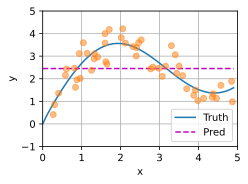

In [26]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数注意力汇聚

如果一个键$x_i$越是接近给定的查询$x$，那么分配给这个键对应值$y_i$的注意力权重就会越大，也就“获得了更多的注意力”。
值得注意的是，Nadaraya-Watson核回归是一个非参数模型，因此，它是非参数的注意力汇聚（nonparametric attention pooling）模型。 接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。 你会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

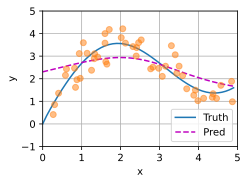

In [27]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在，我们来观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

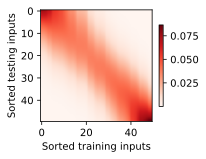

In [28]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')